In [1]:
pip install -q xgboost mplhep onnxmltools onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
from time import time
import mplhep as hep
import matplotlib.pyplot as plt
import xgboost as xgb

hep.style.use("CMS")
plt.rcParams["figure.dpi"] = 400

In [3]:
import pandas as pd

start_time = time()
df = pd.read_parquet("./preprocessed_data_v1.4.1/processed_data.parquet")
print(f"Loaded data with {len(df)} samples and {len(df.columns)} features")
print(f"Data loading took {time() - start_time:.2f} seconds")

Loaded data with 18739184 samples and 72 features
Data loading took 221.63 seconds


In [4]:
output_dir = 'outputs_test'
os.makedirs(output_dir, exist_ok=True)
seed = 42
config_dict = {
        "output_dir": output_dir,
        "seed": seed,
}

In [16]:
# # Get unique values
# pdgid_values = df['l1_pdgId'].unique() # should be same for l2
# charge_values = df['l1_charge'].unique() # should be same for l2

# # One-hot encode lepton_pdgid
# for val in pdgid_values:
#     df.loc[:, f'lepton_pdgid_{val}'] = (df['l1_pdgId'] == val).astype(int)
#     df.loc[:, f'lepton_pdgid_{val}'] = (df['l2_pdgId'] == val).astype(int)

# # One-hot encode lepton_charge
# for val in charge_values:
#     df.loc[:, f'lepton_charge_{val}'] = (df['l1_charge'] == val).astype(int)
#     df.loc[:, f'lepton_charge_{val}'] = (df['l2_charge'] == val).astype(int)

# # Drop original columns
# df = df.drop(columns=['l1_pdgId', 'l1_charge', 'l2_pdgId', 'l2_charge'])

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare features and target
exclude_cols = ["HH", "bkg", "weight", "event_no"]
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].values
y = df["HH"].values
weights = df["weight"].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
X, y, weights, test_size=0.2, random_state=seed, stratify=y
)

X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(
X_train, y_train, weights_train, test_size=0.2, random_state=seed, stratify=y_train
)

In [45]:
df.columns

Index(['l1_Px', 'l1_Py', 'l1_Pz', 'l1_E', 'l1_pdgId', 'l1_charge',
       'leading_lepton_pt', 'l2_Px', 'l2_Py', 'l2_Pz', 'l2_E', 'l2_pdgId',
       'l2_charge', 'subleading_lepton_pt', 'j1_Px', 'j1_Py', 'j1_Pz', 'j1_E',
       'j1_btag', 'j2_Px', 'j2_Py', 'j2_Pz', 'j2_E', 'j2_btag', 'j3_Px',
       'j3_Py', 'j3_Pz', 'j3_E', 'j3_btag', 'j4_Px', 'j4_Py', 'j4_Pz', 'j4_E',
       'j4_btag', 'j8_Px', 'j8_Py', 'j8_Pz', 'j8_E', 'j8_btag', 'j8_tau1',
       'j8_tau2', 'j8_tau3', 'j8_tau4', 'j8_msoftdrop', 'met_Px', 'met_Py',
       'met_E', 'HT', 'met_LD', 'dR_l1_l2', 'dR_j1_j2', 'dR_dilepton_dijet',
       'dR_dilepton_dibjet', 'abs_dphi_met_dilepton', 'abs_dphi_met_dibjet',
       'min_dR_l1_ak4jets', 'min_dR_l2_ak4jets', 'min_dR_lead_bjet_leptons',
       'min_dR_sublead_bjet_leptons', 'min_dR_ak4jets', 'min_abs_dphi_ak4jets',
       'di_bjet_mass', 'di_lepton_mass', 'di_lepton_met_mass',
       'di_lepton_dijet_met_mass', 'VBF_tag', 'boosted_tag', 'run_year',
       'event_no', 'weight', 

In [6]:
# Create DMatrix for training and testing

# Add Gaussian noise to features during training
# def add_feature_noise(X, noise_level=0.01):
#     noise = np.random.normal(0, noise_level, X.shape)
#     return X + noise

# X_train_noisy = add_feature_noise(X_train, noise_level=0.01)
# dtrain = xgb.DMatrix(X_train_noisy, label=y_train, weight=weights_train)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid, weight=weights_valid)
dtest = xgb.DMatrix(X_test, label=y_test, weight=weights_test)

In [50]:
n_estimators = 200
learning_rate = 0.3
max_depth = 3

config_dict.update( {
    "n_estimators": n_estimators,
    "learning_rate": learning_rate,
    "max_depth": max_depth,
})

params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"],
    "max_depth": max_depth,
    "learning_rate": learning_rate,
    "tree_method": "hist",
    "device": "cuda", 
    "random_state": seed,
    "max_delta_step": 1, # for unbalanced classification 0-10
}

config_dict.update(params)

with open(f"{output_dir}/config.json", "w") as f:
    json.dump(config_dict, f, indent=4)
print(f"Saved config to {output_dir}/config.json")

num_boost_round = n_estimators

evals = [(dtrain, "train"), (dvalid, "valid")]
evals_result = {}

early_stop = xgb.callback.EarlyStopping(
    rounds=30,
    metric_name="logloss",  # Monitor logloss
    data_name="valid",      # On the validation set
    save_best=True
)

learning_rates = []

def custom_learning_rate(current_iter):
    base_lr = learning_rate
    lr = base_lr * (0.99 ** current_iter)
    learning_rates.append(lr)
    return lr

lr_scheduler = xgb.callback.LearningRateScheduler(custom_learning_rate)

bst = xgb.train(
params,
dtrain,
num_boost_round=num_boost_round, # set large, let early stopping choose
evals=evals,
callbacks=[early_stop],
verbose_eval=True,
evals_result=evals_result
)

# Now use evals_result directly
results = evals_result

print(f"Training stopped at round: {bst.best_iteration}")
print(f"Best validation score: {bst.best_score:.4f}")
print(f"Total rounds that could have run: {num_boost_round}")

Saved config to outputs_test/config.json
[0]	train-logloss:0.61561	train-auc:0.84911	valid-logloss:0.61569	valid-auc:0.84810
[1]	train-logloss:0.55734	train-auc:0.86173	valid-logloss:0.55750	valid-auc:0.86064
[2]	train-logloss:0.51114	train-auc:0.88745	valid-logloss:0.51135	valid-auc:0.88660
[3]	train-logloss:0.47878	train-auc:0.89091	valid-logloss:0.47928	valid-auc:0.88980
[4]	train-logloss:0.45449	train-auc:0.89386	valid-logloss:0.45508	valid-auc:0.89303
[5]	train-logloss:0.43569	train-auc:0.89879	valid-logloss:0.43624	valid-auc:0.89788
[6]	train-logloss:0.42097	train-auc:0.90129	valid-logloss:0.42157	valid-auc:0.90060
[7]	train-logloss:0.41065	train-auc:0.90363	valid-logloss:0.41100	valid-auc:0.90315
[8]	train-logloss:0.40012	train-auc:0.90714	valid-logloss:0.40078	valid-auc:0.90643
[9]	train-logloss:0.39178	train-auc:0.90894	valid-logloss:0.39256	valid-auc:0.90818
[10]	train-logloss:0.38632	train-auc:0.90952	valid-logloss:0.38744	valid-auc:0.90860
[11]	train-logloss:0.37981	train-a

In [35]:
# train-logloss:0.31355	train-auc:0.93662	valid-logloss:0.32045

In [36]:
# Predict probabilities for the test set
y_pred = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

# Use evals_result directly (already populated during training)
# results = evals_result  # or just use evals_result everywhere

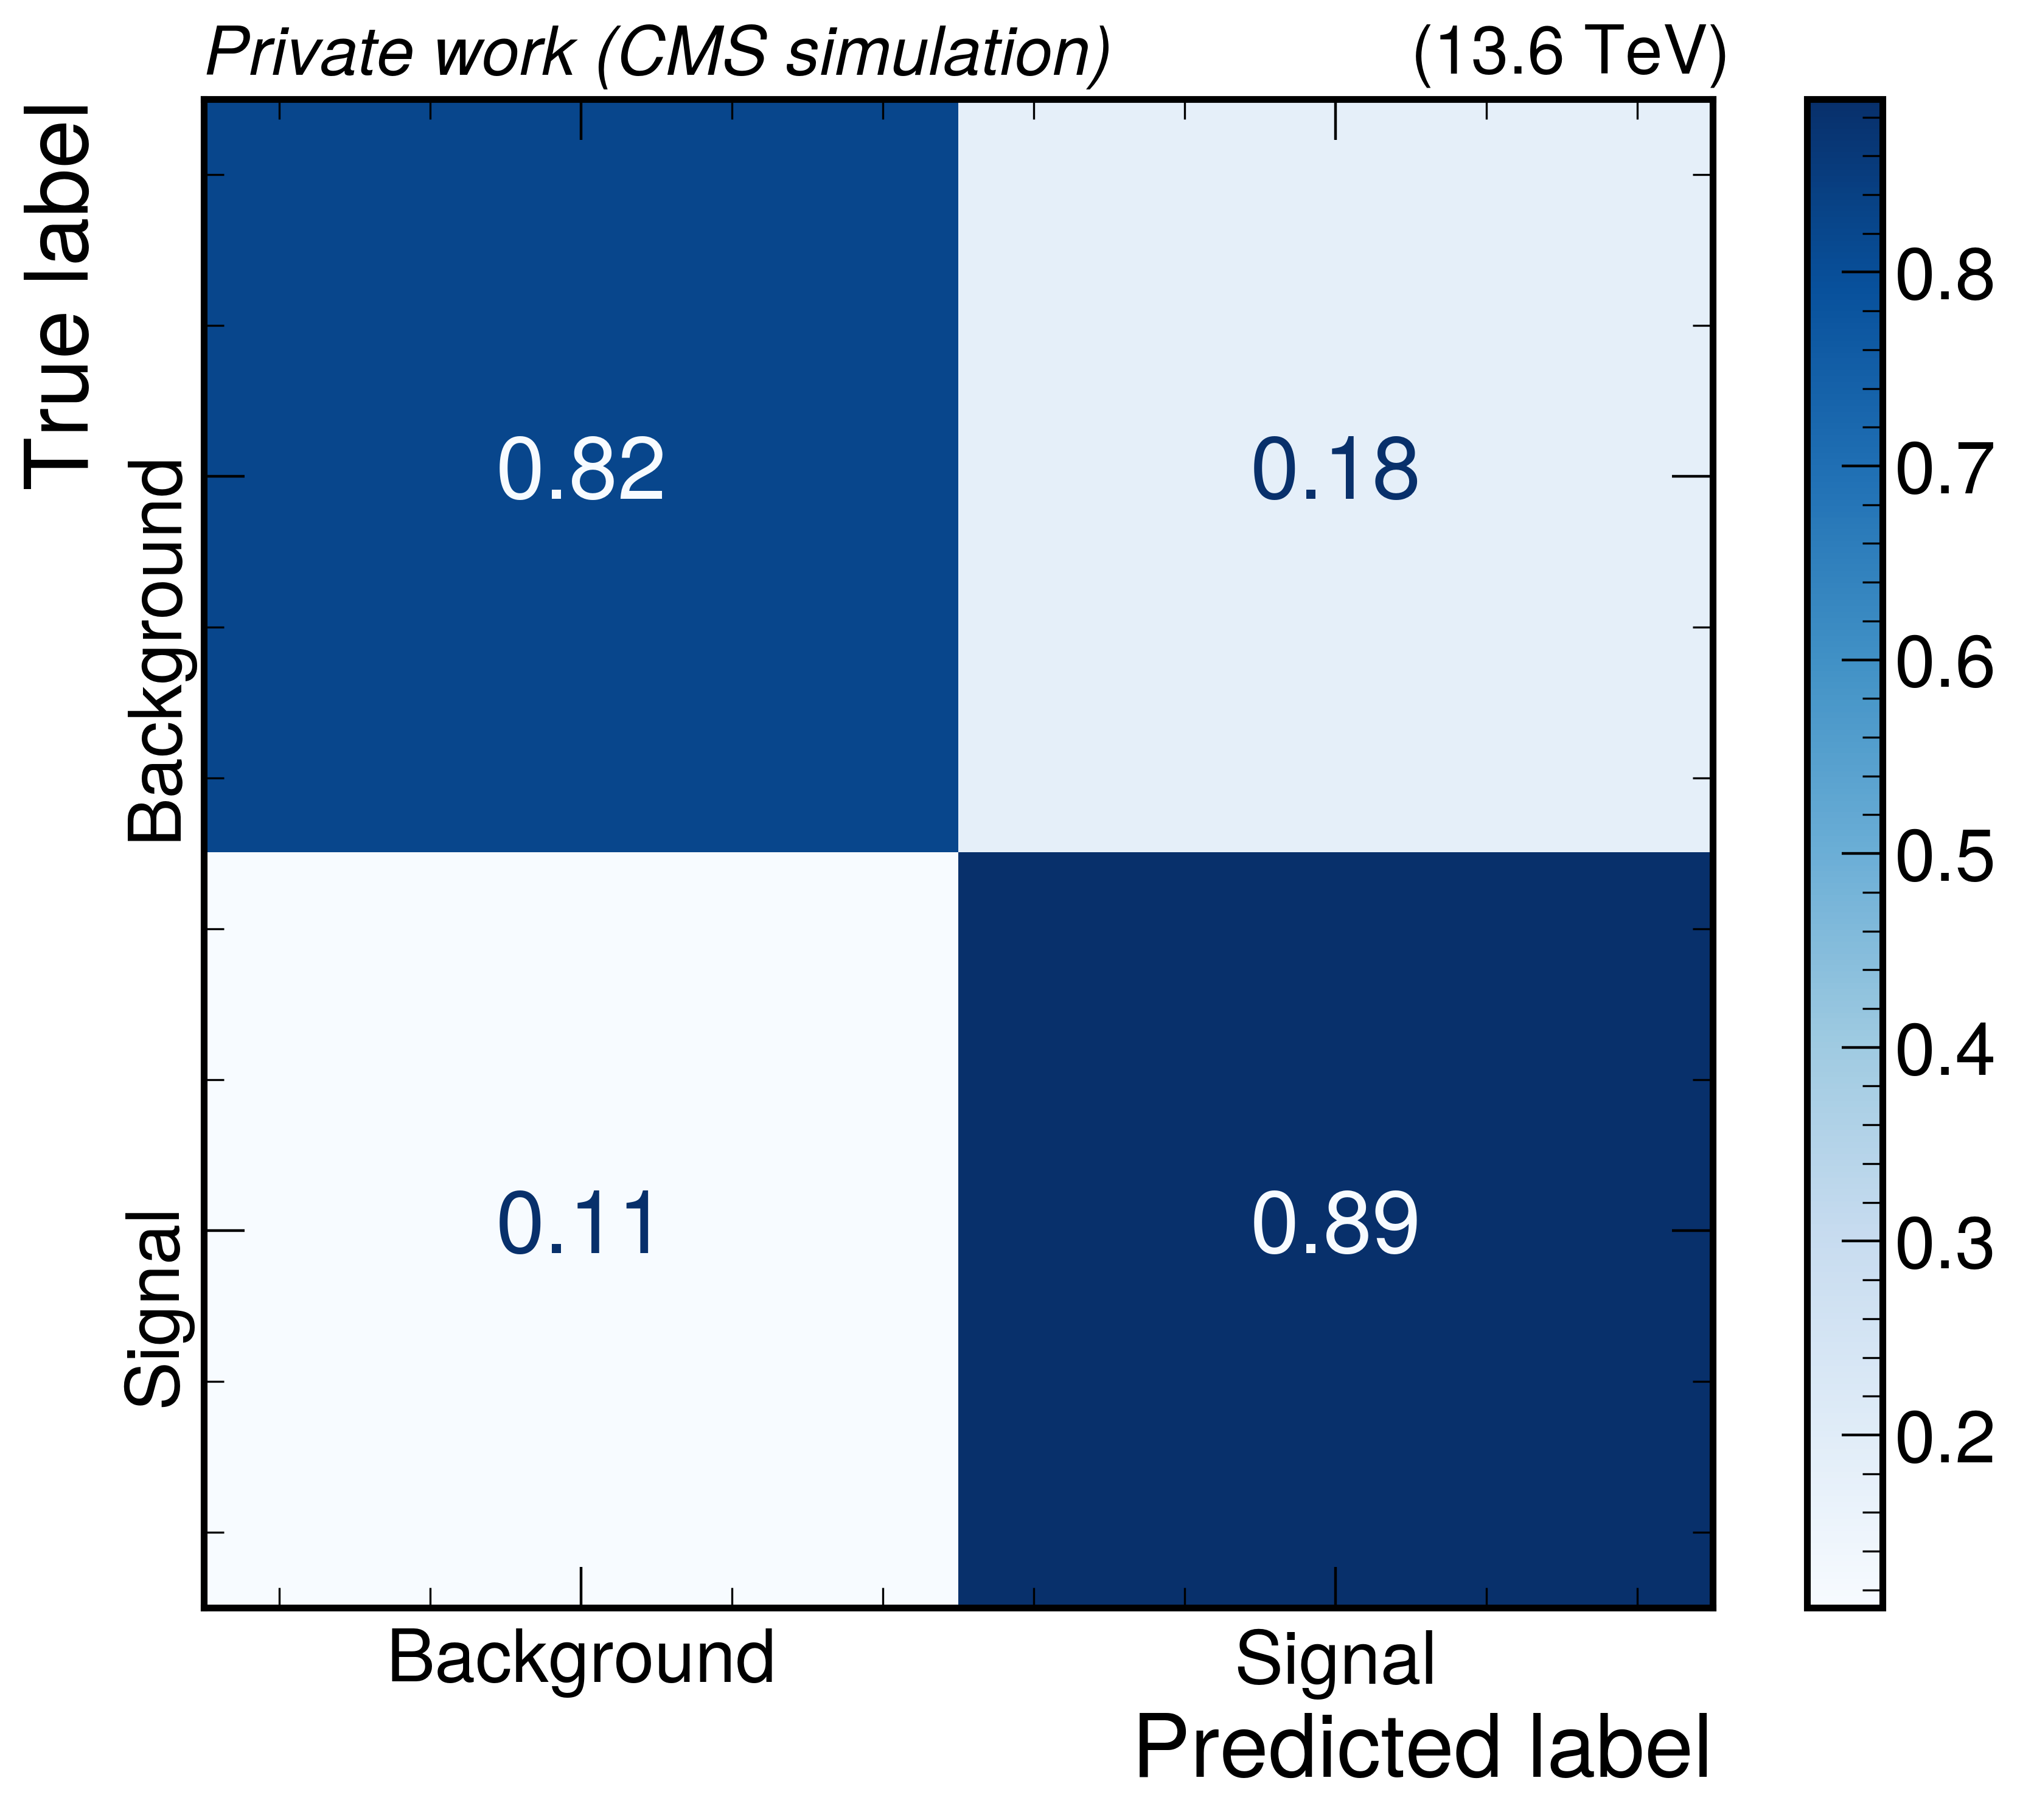

Confusion matrix saved to outputs_test/xgb_confusion_matrix.png


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for validation set
y_pred_label = (y_pred > 0.5).astype(int)

# Compute confusion matrix (normalized)
cm = confusion_matrix(
    y_test, y_pred_label, sample_weight=weights_test, normalize="true"
)
display_labels = ["Background", "Signal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format=".2f")
disp.ax_.set_yticklabels(display_labels, rotation=90)

disp.ax_.text(
    0.0,
    1.05,
    "Private work (CMS simulation)",
    fontsize=20,
    fontproperties="Tex Gyre Heros:italic",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)
disp.ax_.text(
    0.8,
    1.05,
    "(13.6 TeV)",
    fontsize=20,
    fontproperties="Tex Gyre Heros",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)

# Adjust colorbar to have the same height as the confusion matrix plot
cbar = disp.figure_.axes[-1]
cbar.set_position(
    [
        cbar.get_position().x0,
        disp.ax_.get_position().y0,
        cbar.get_position().width,
        disp.ax_.get_position().height,
    ]
)
plt.savefig(f"{output_dir}/xgb_confusion_matrix.png")
plt.show()
print(f"Confusion matrix saved to {output_dir}/xgb_confusion_matrix.png")

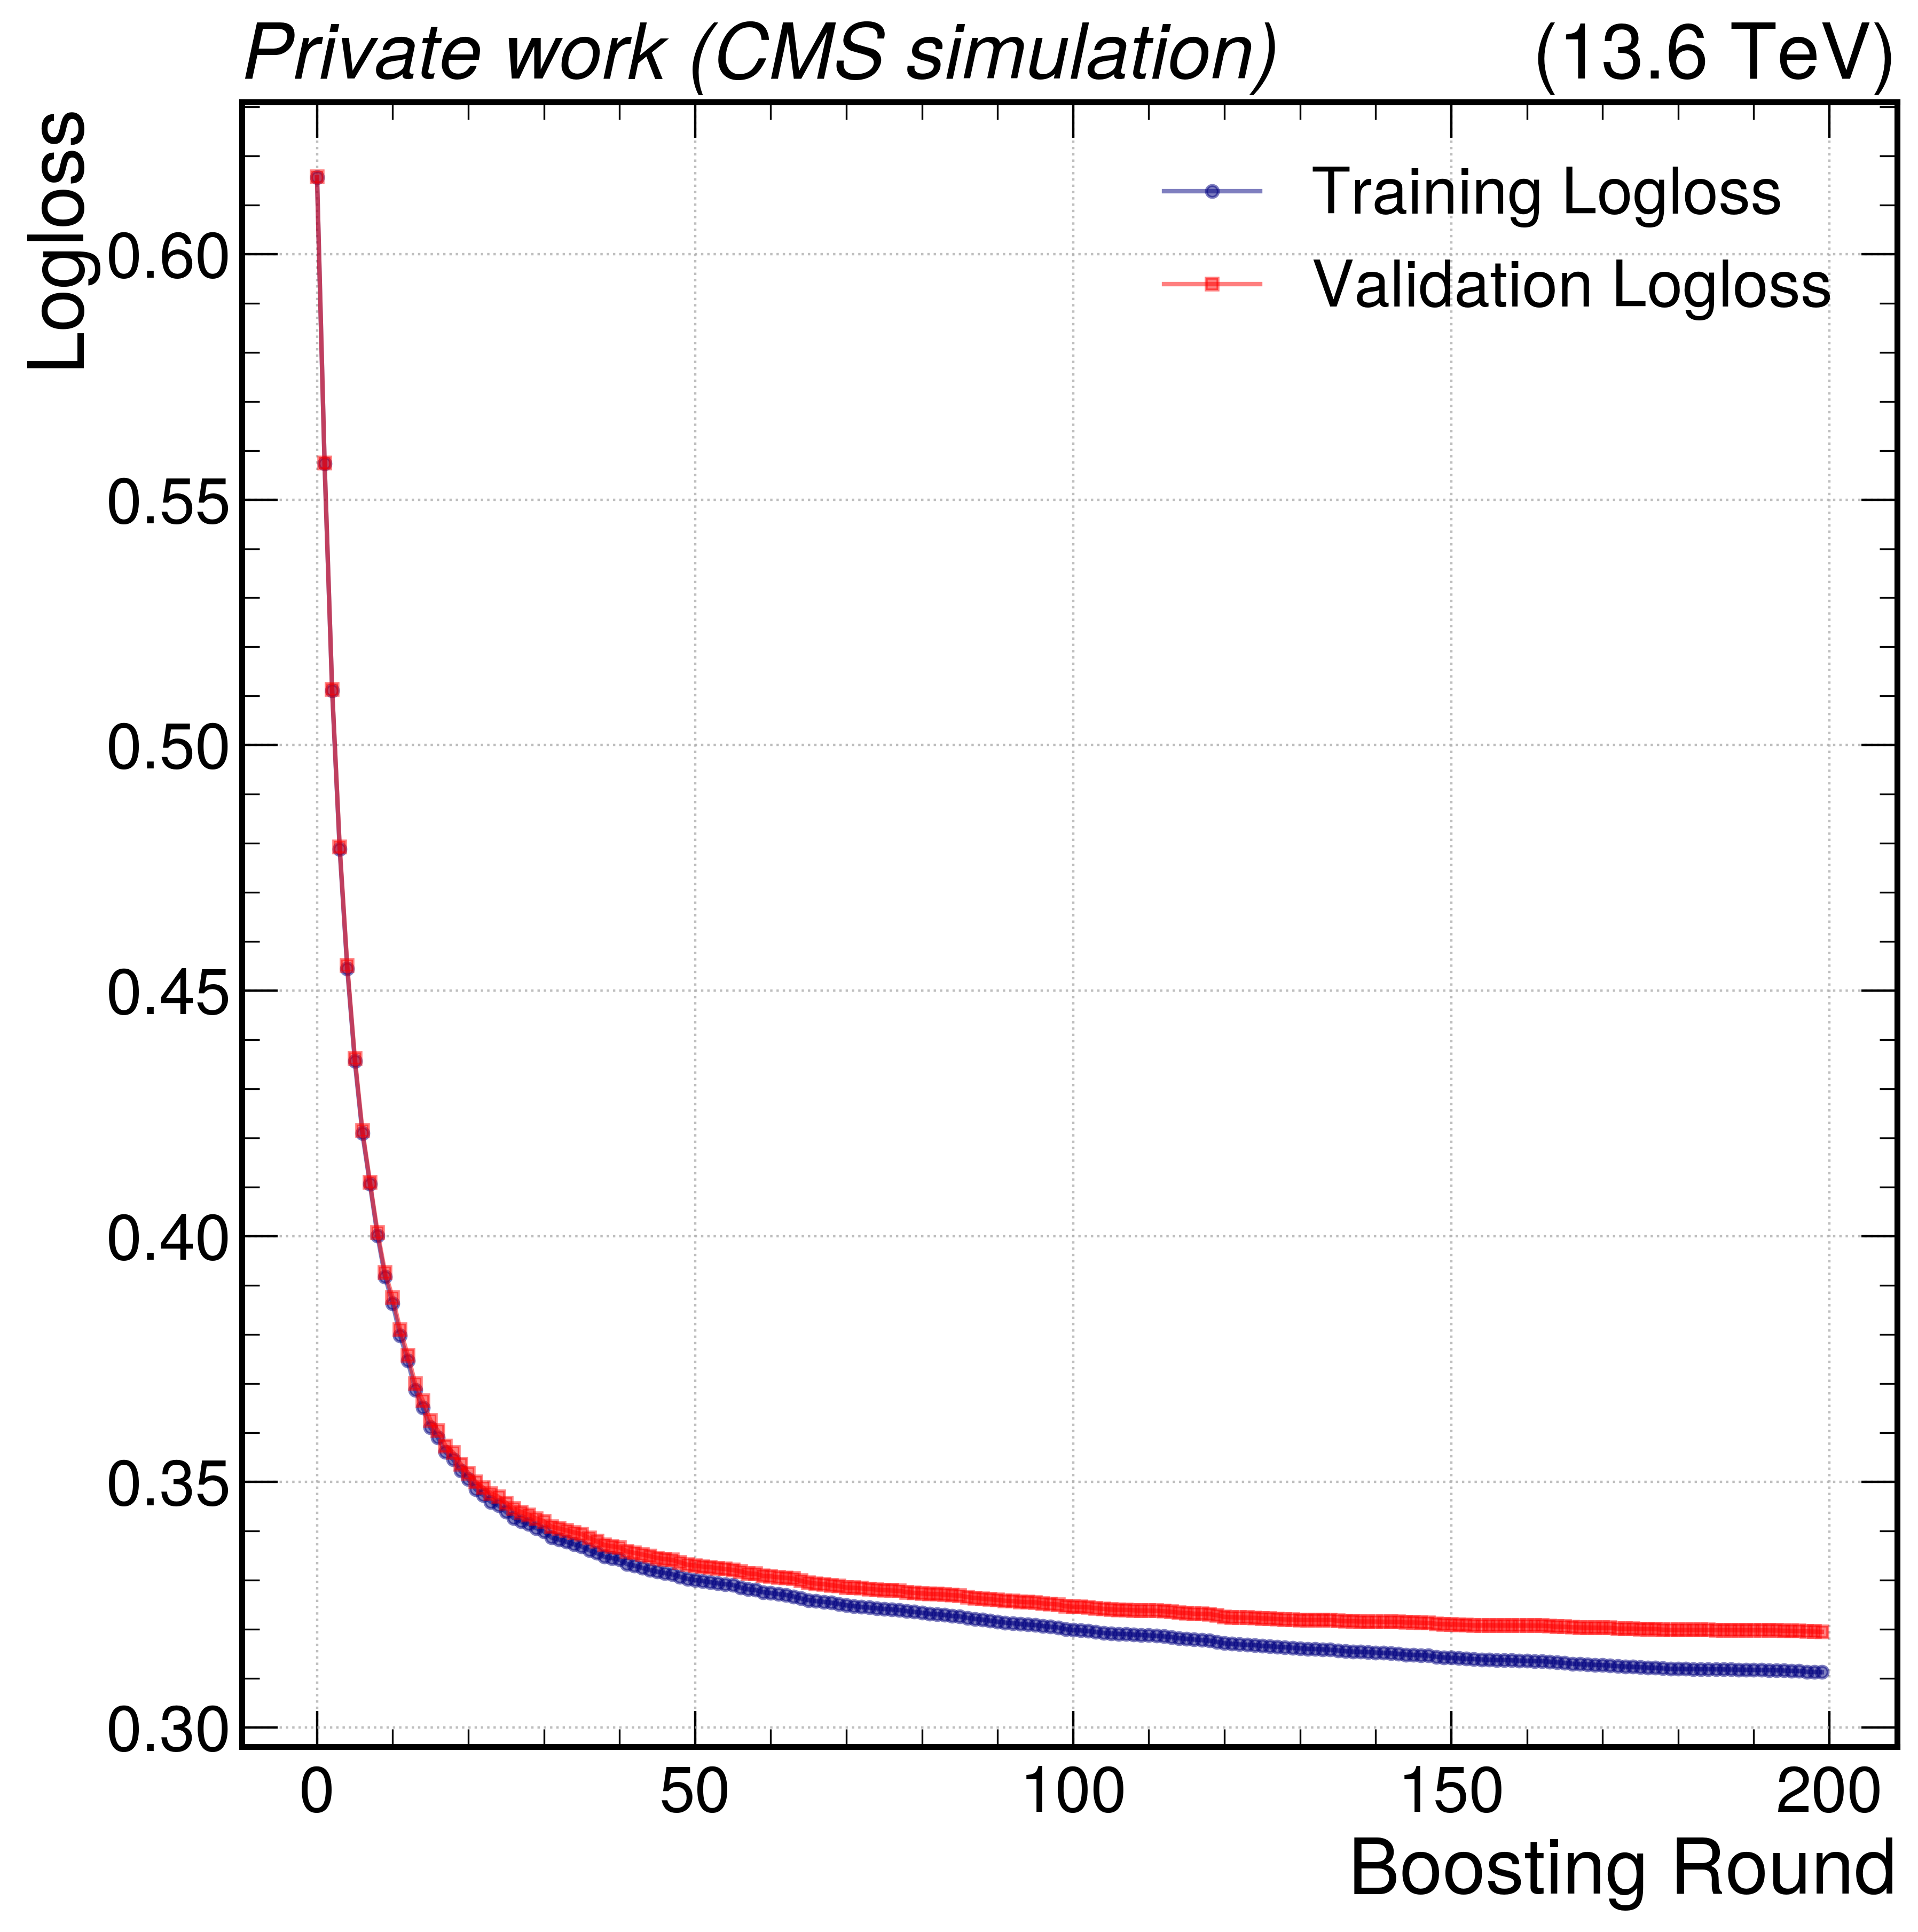

In [39]:
plt.figure()
plt.plot(
    results["train"]["logloss"],
    label="Training Logloss",
    color="navy",
    marker="o",
    markersize=4,
    alpha=0.5,
)
plt.plot(
    results["valid"]["logloss"],
    label="Validation Logloss",
    color="red",
    marker="s",
    markersize=4,
    alpha=0.5,
)
plt.xlabel("Boosting Round")
plt.ylabel("Logloss")
plt.title(
    "Private work (CMS simulation)",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=8, fontproperties="Tex Gyre Heros"
)
plt.legend()
# plt.yscale("log")
plt.grid(True)
plt.savefig(f"{output_dir}/xgb_loss_curve.png")
plt.show()

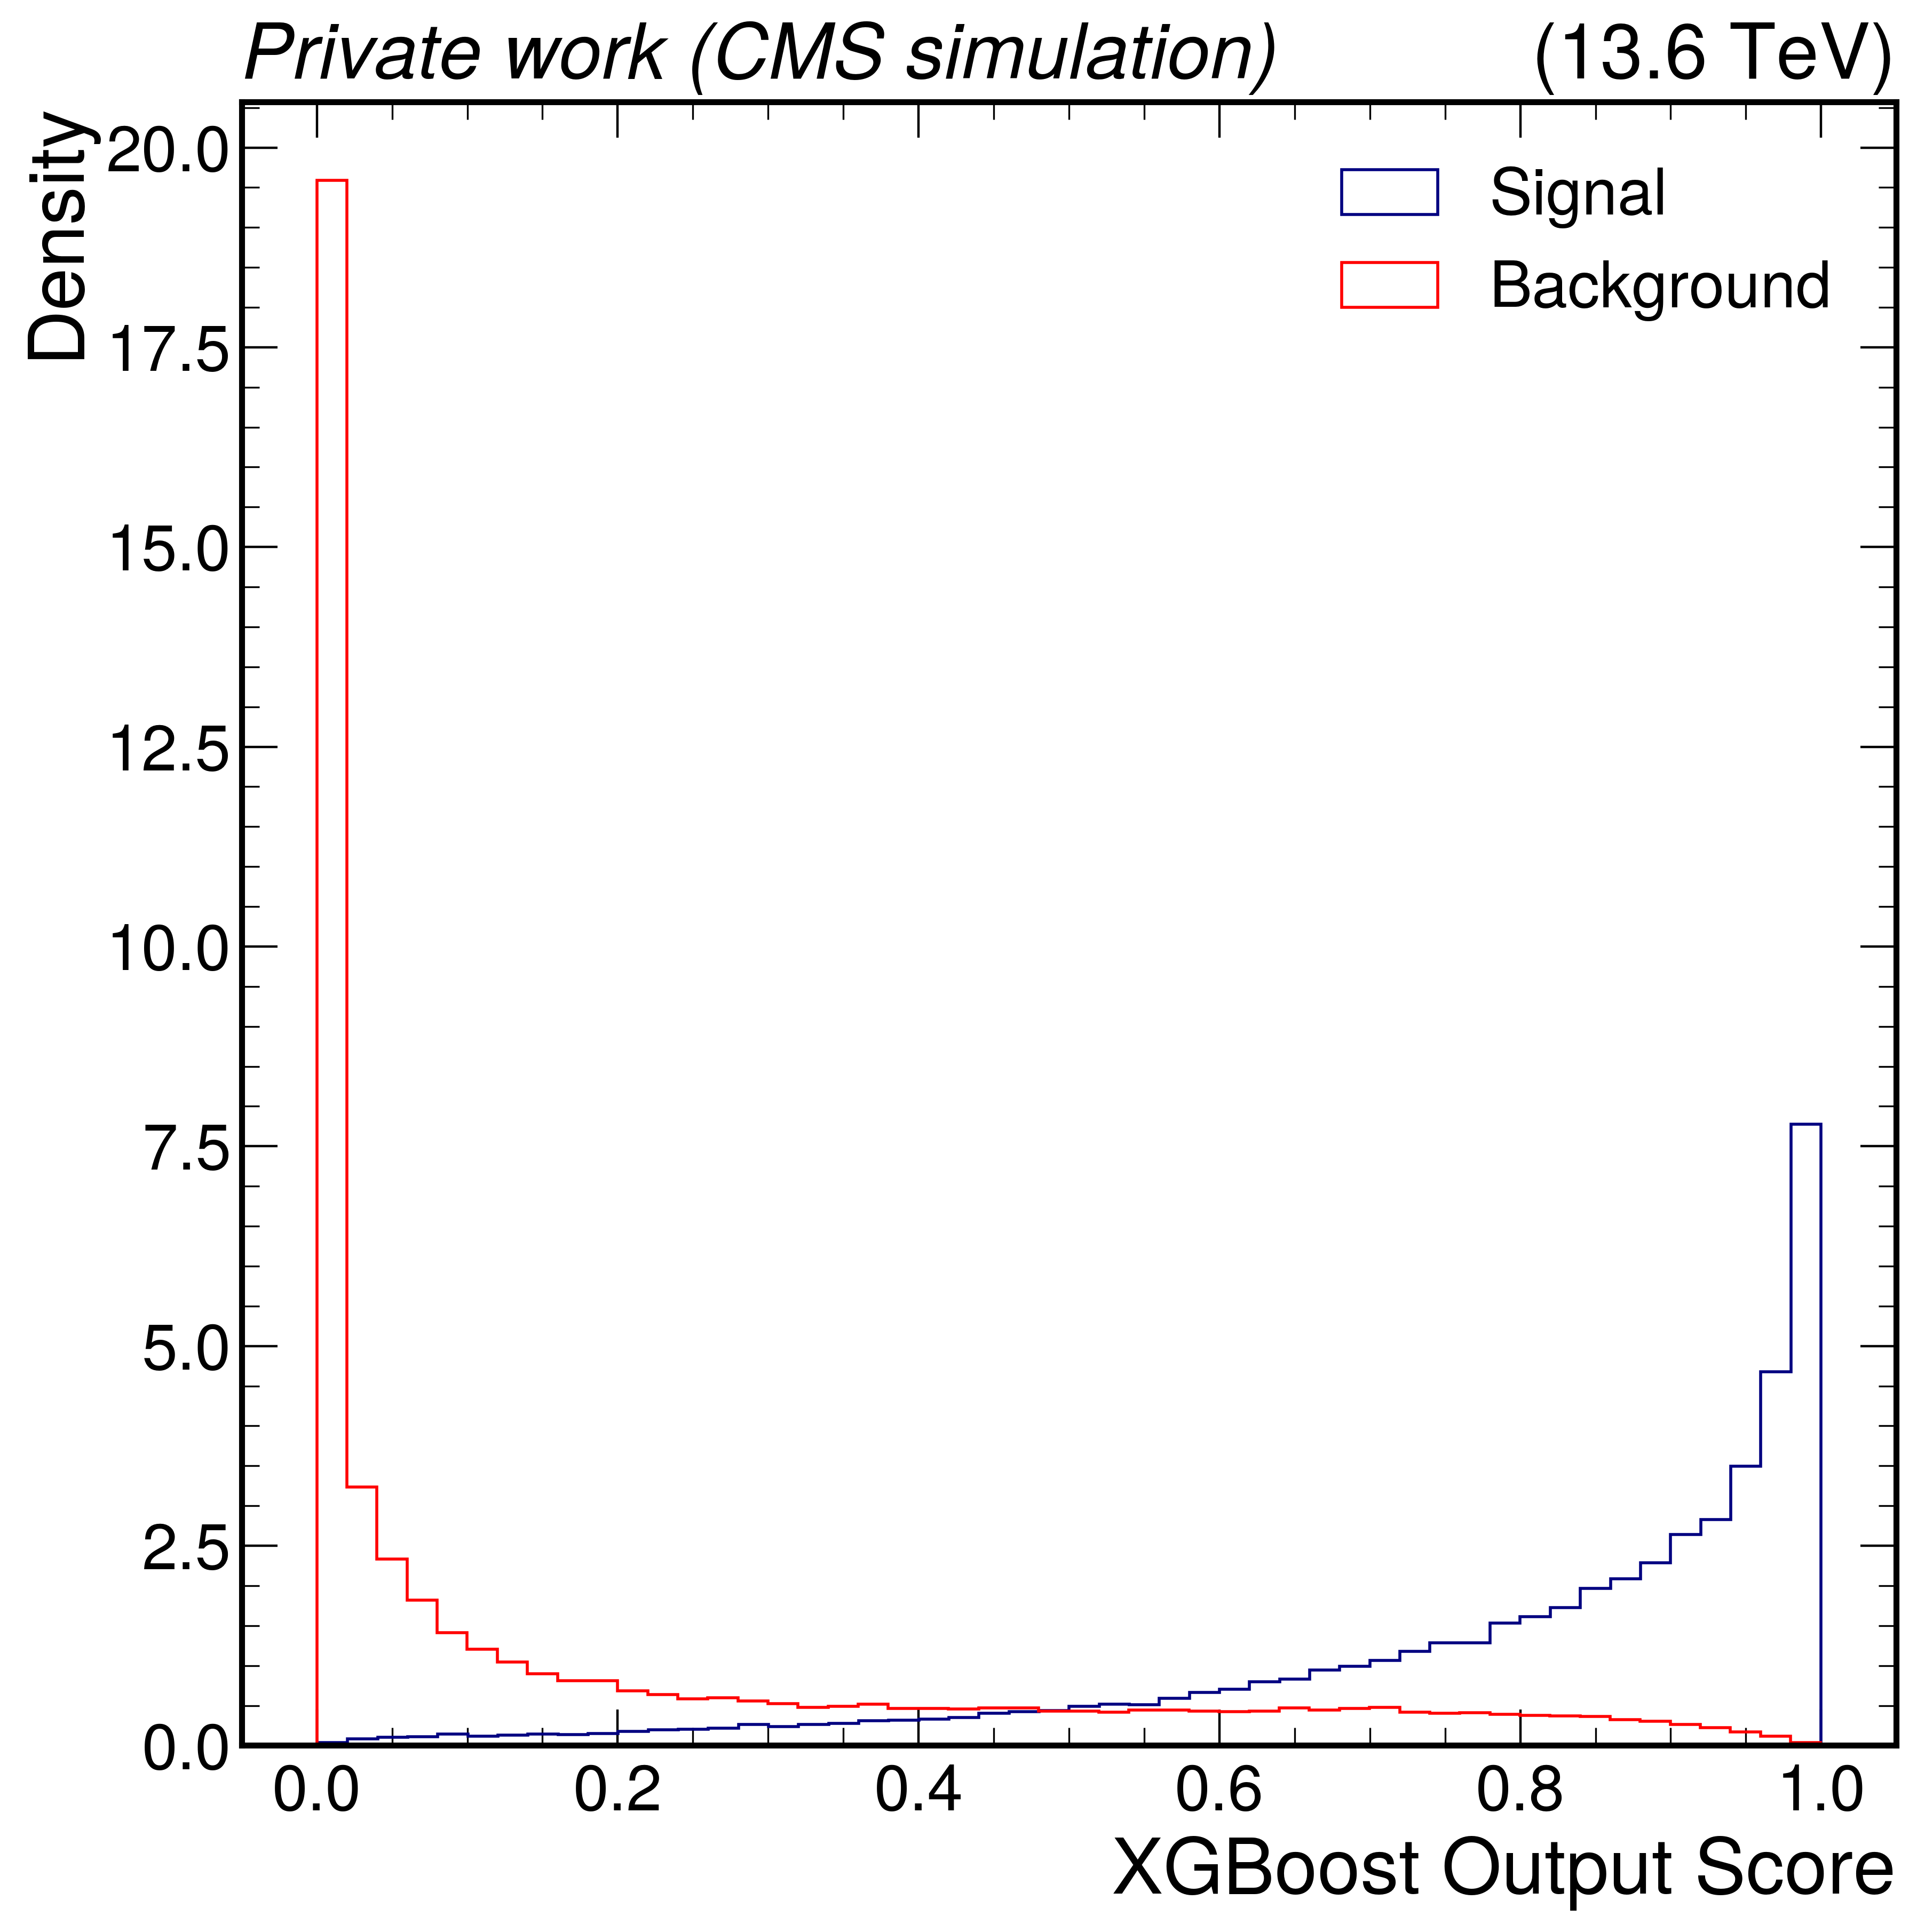

Score distribution saved to outputs_test/xgb_score_dist_normalised.png


In [40]:
# Plot score distribution for signal and background (normalised)
plt.figure()
plt.hist(
    y_pred[y_test == 1],
    weights=weights_test[y_test == 1],
    bins=50,
    histtype="step",
    color="navy",
    label="Signal",
    density=True,  # Normalise histogram
)
plt.hist(
    y_pred[y_test == 0],
    weights=weights_test[y_test == 0],
    bins=50,
    histtype="step",
    color="red",
    label="Background",
    density=True,  # Normalise histogram
)
plt.xlabel("XGBoost Output Score")
plt.ylabel("Density")
plt.legend()
# plt.gca().set_yscale("log")
plt.title(
    "Private work (CMS simulation)",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=8, fontproperties="Tex Gyre Heros"
)
plt.savefig(f"{output_dir}/xgb_score_dist_normalised.png")
plt.show()
print(f"Score distribution saved to {output_dir}/xgb_score_dist_normalised.png")

XGBoost ROC AUC: 0.9338


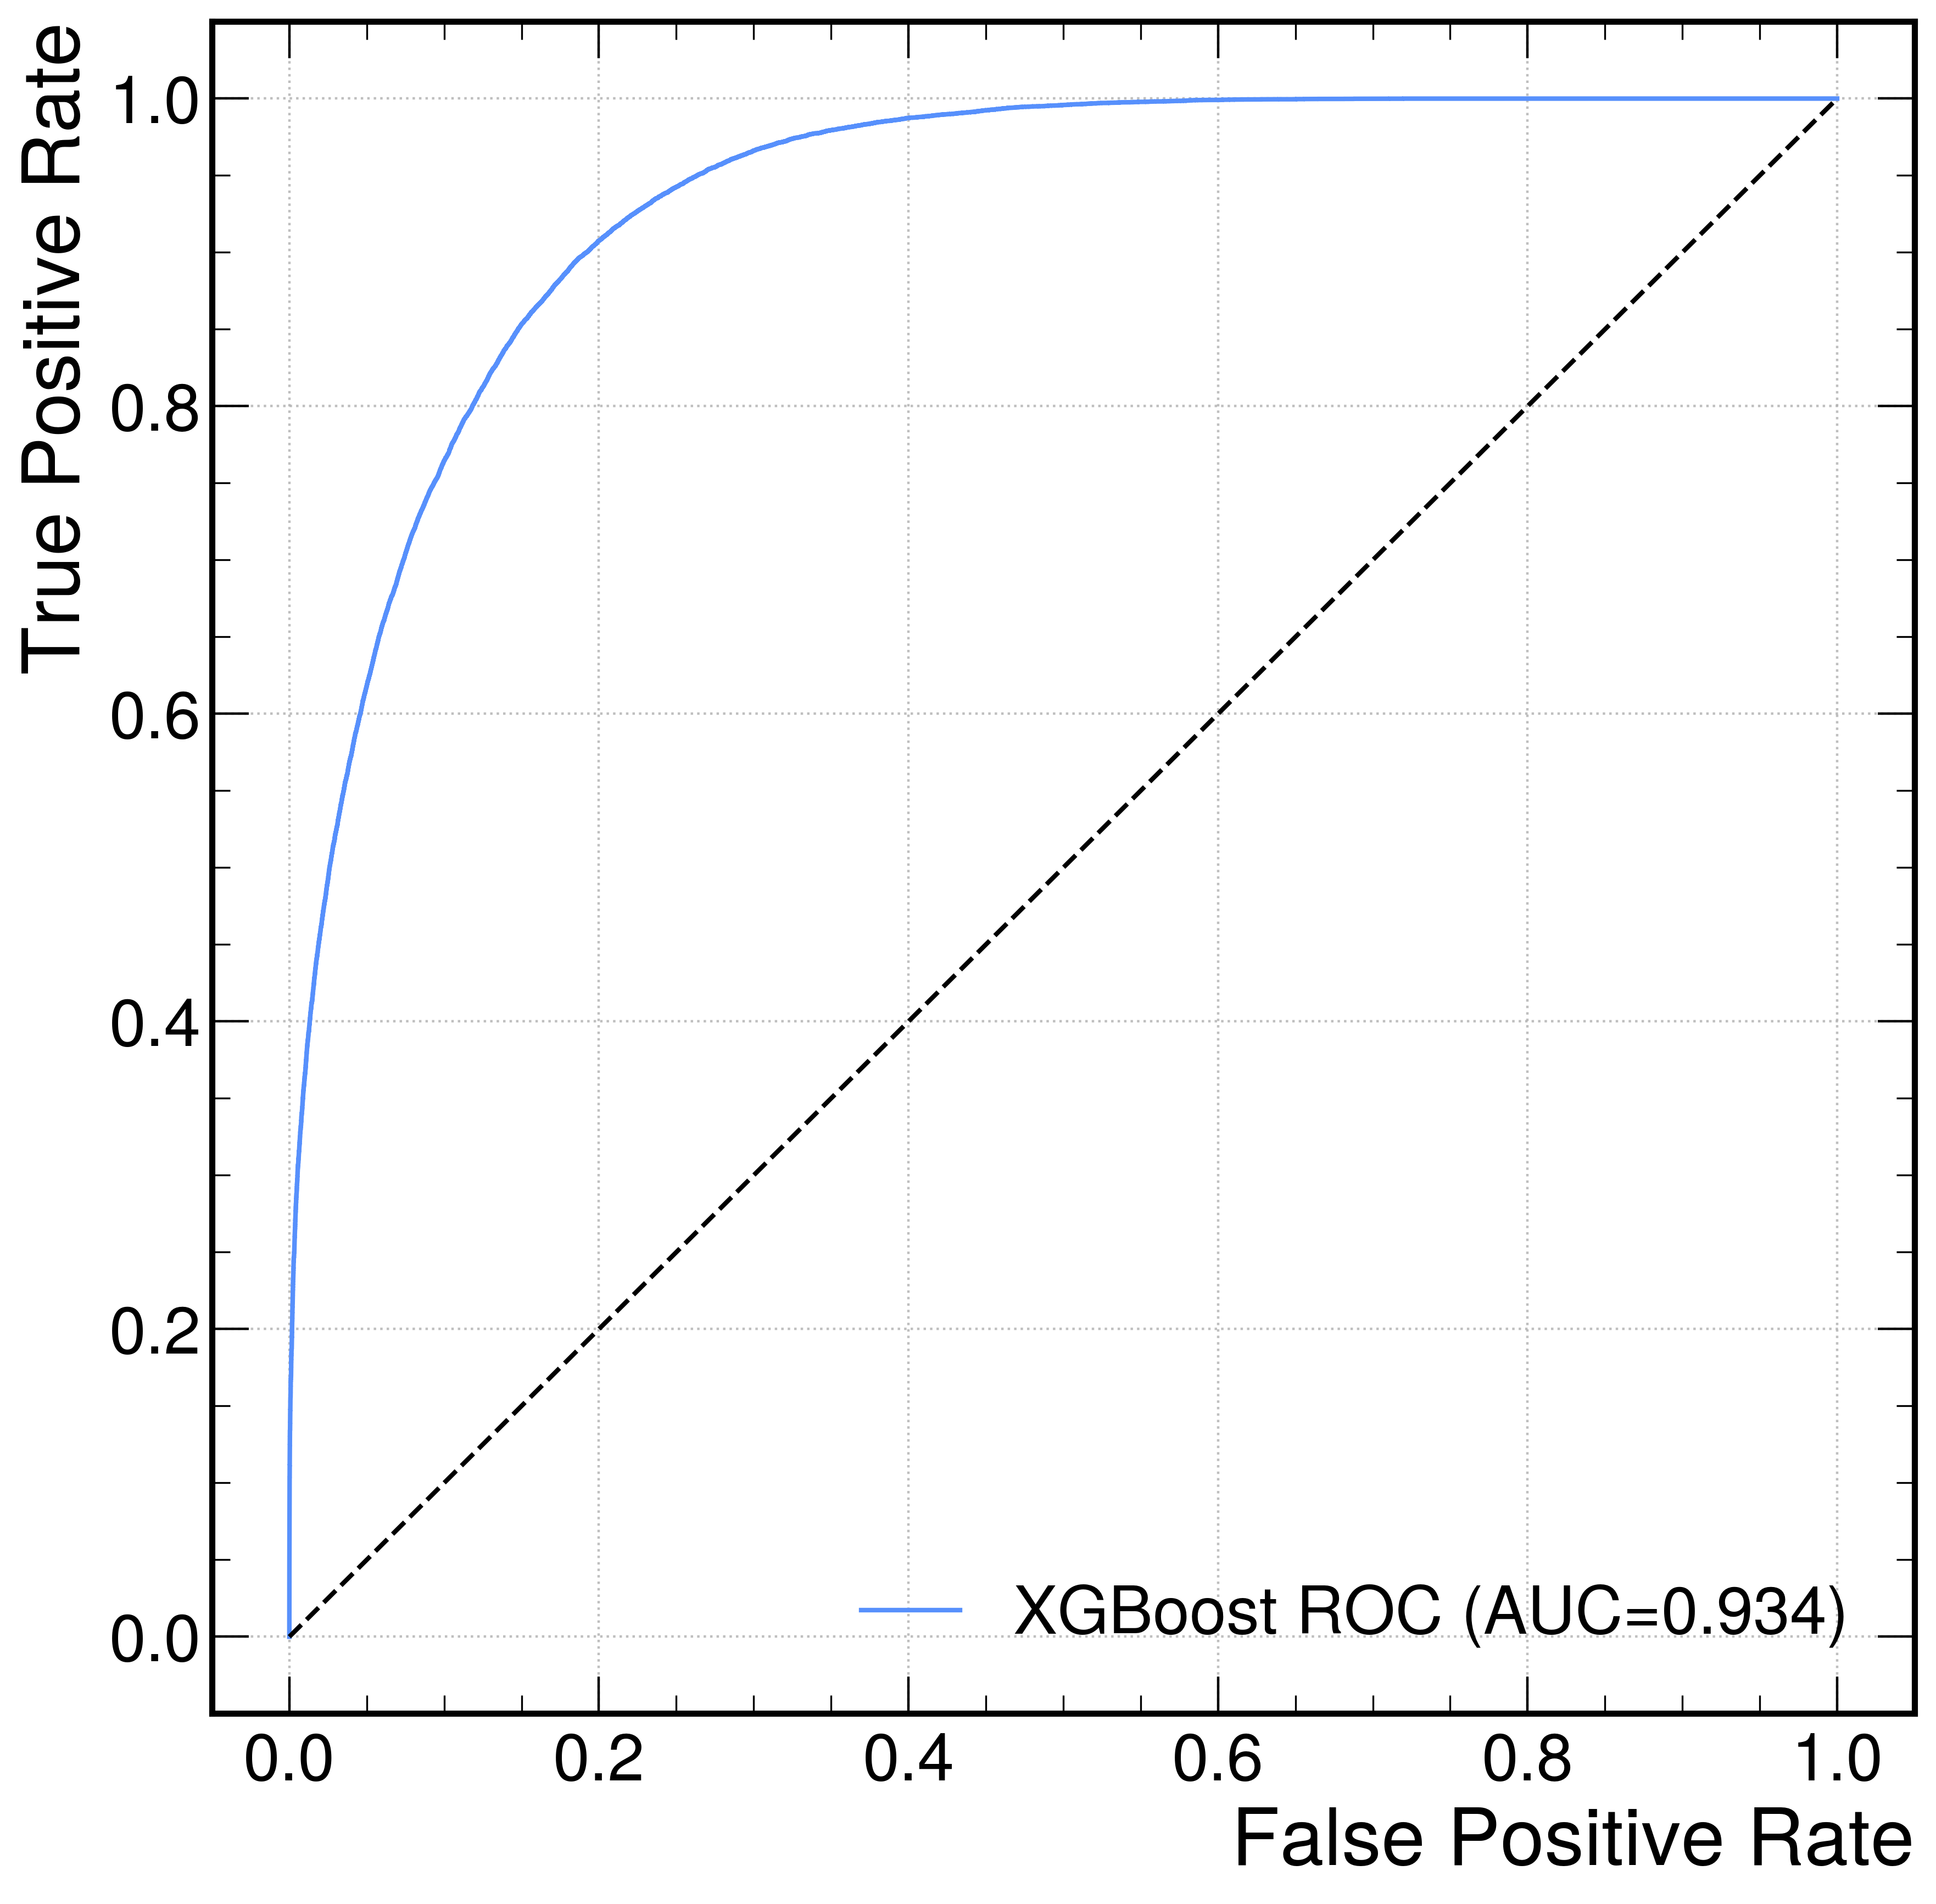

ROC curve saved to outputs_test/xgb_roc_curve.png


In [41]:
# Now you can continue with your plotting and evaluation code
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
print(f"XGBoost ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred, sample_weight=weights_test)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/xgb_roc_curve.png")
plt.show()
print(f"ROC curve saved to {output_dir}/xgb_roc_curve.png")

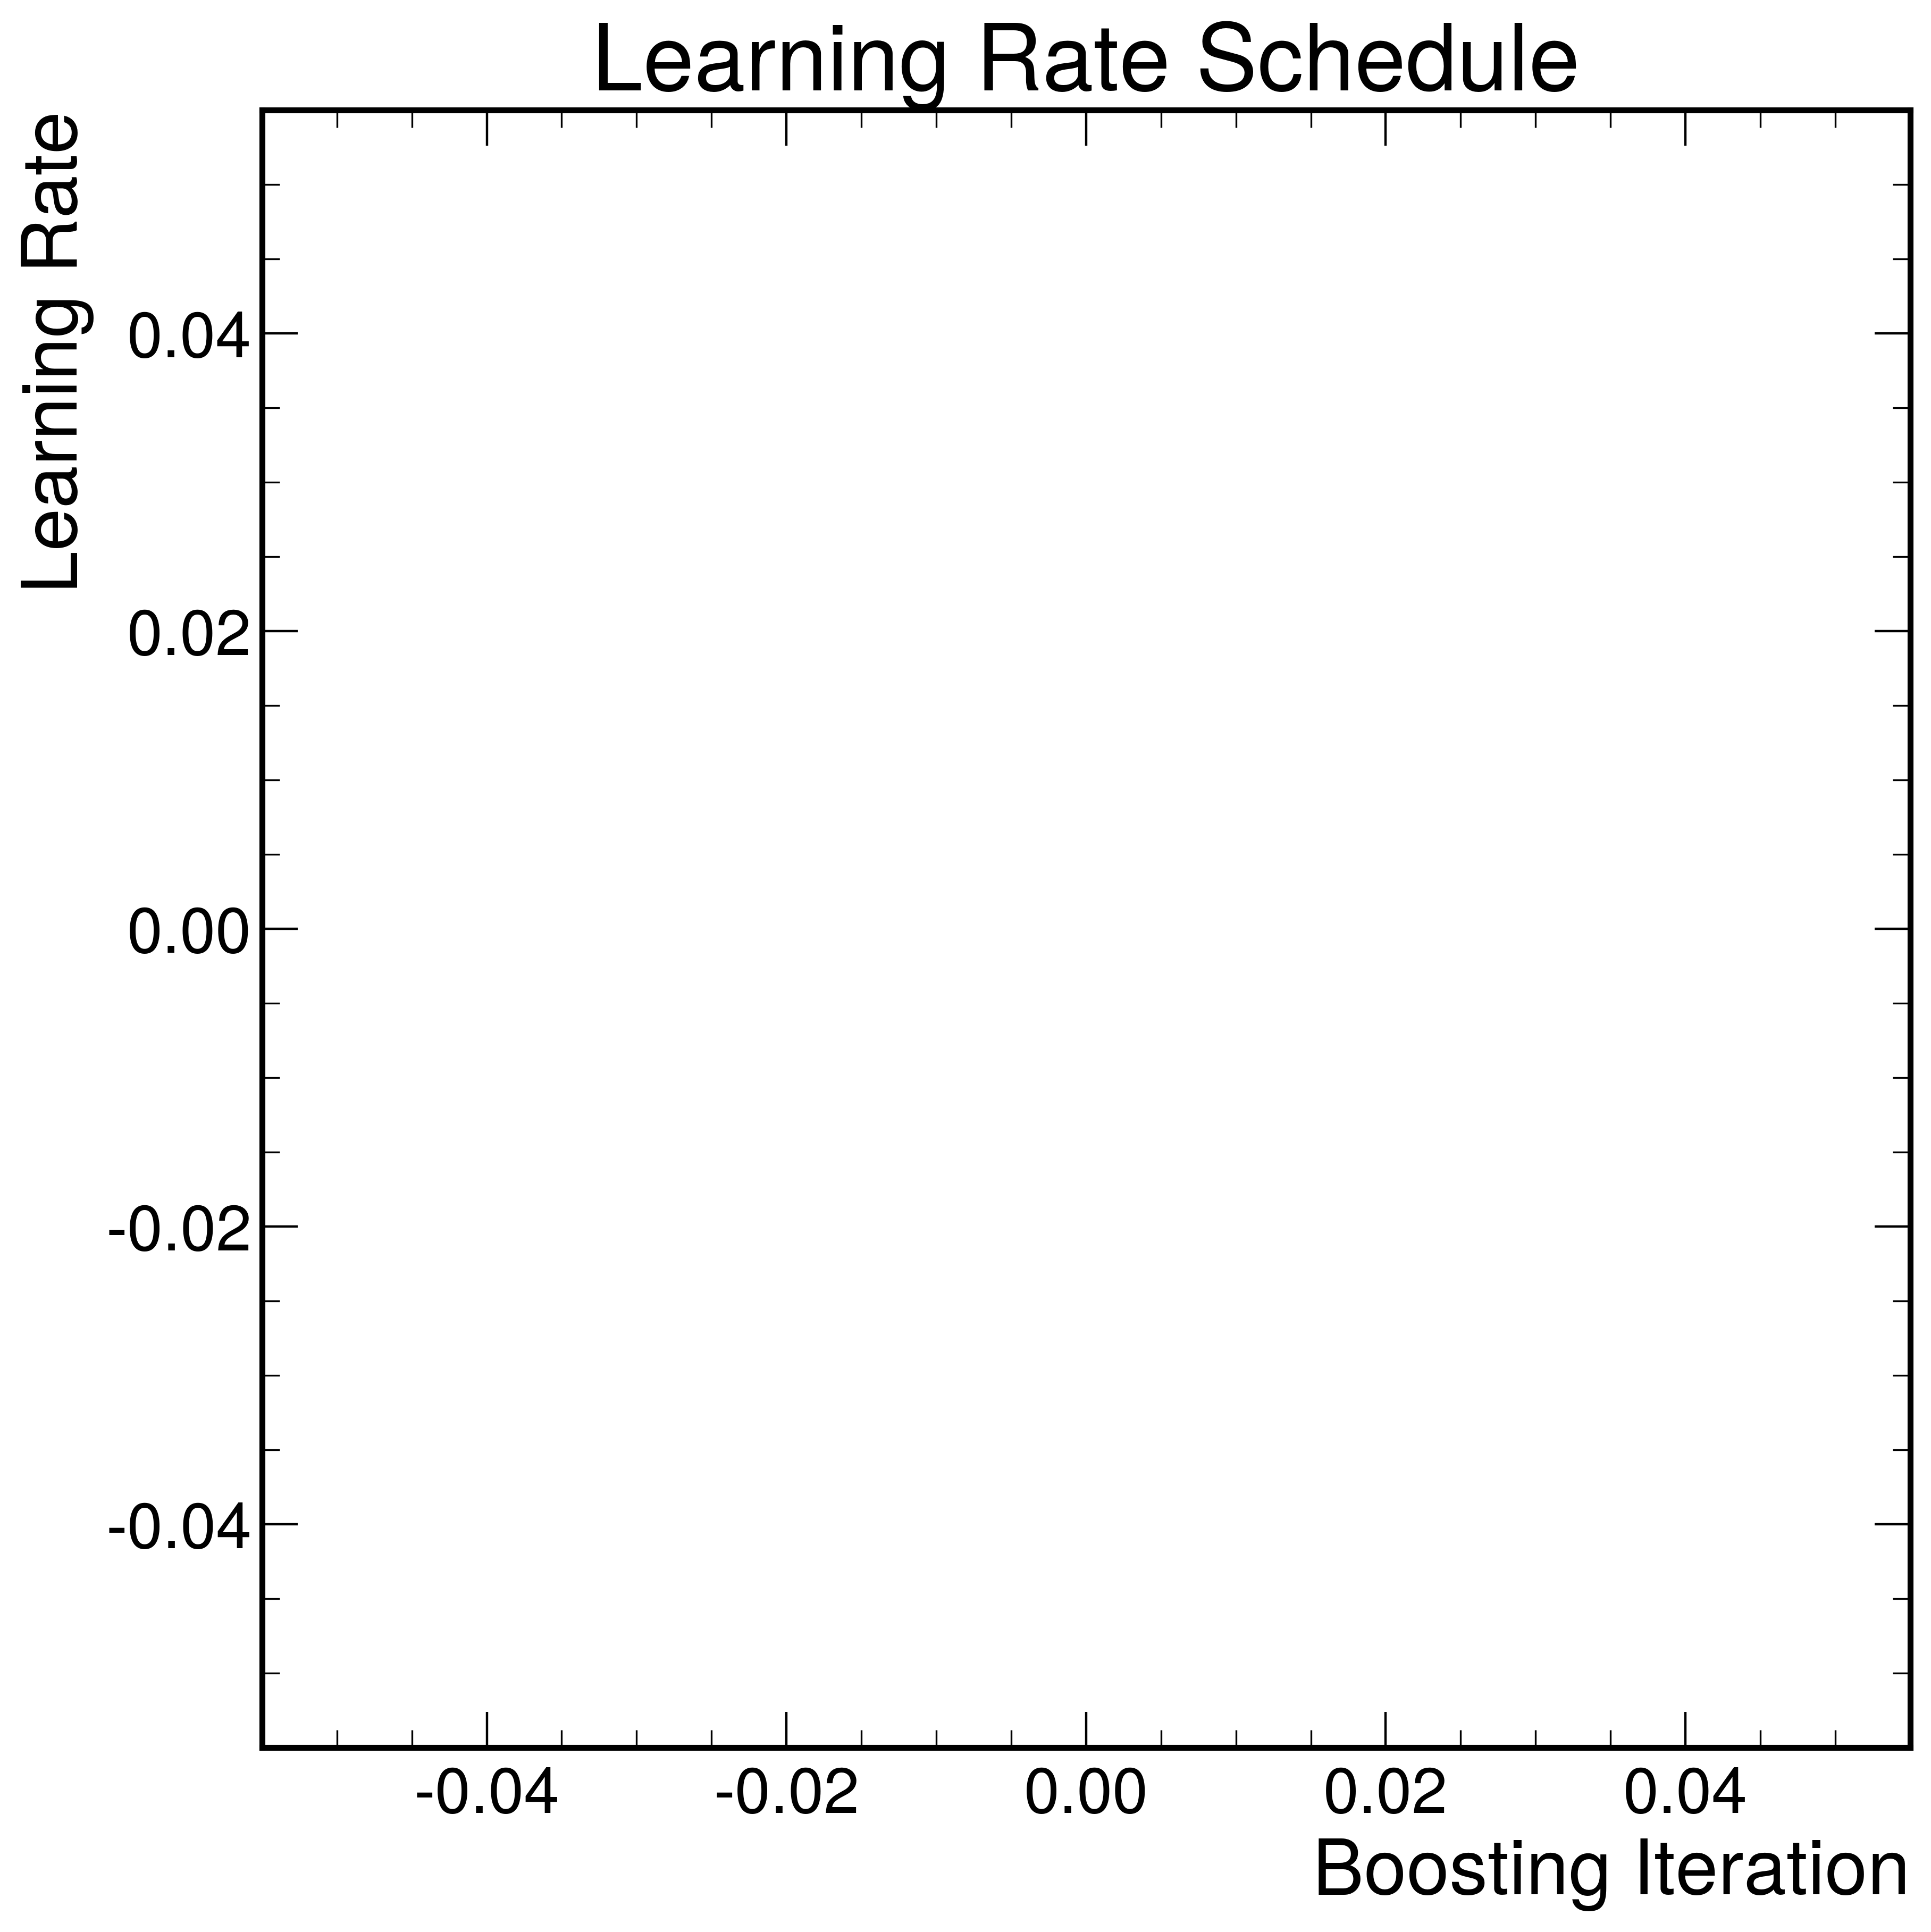

In [42]:
plt.plot(learning_rates)
plt.xlabel('Boosting Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

<Figure size 4000x2400 with 0 Axes>

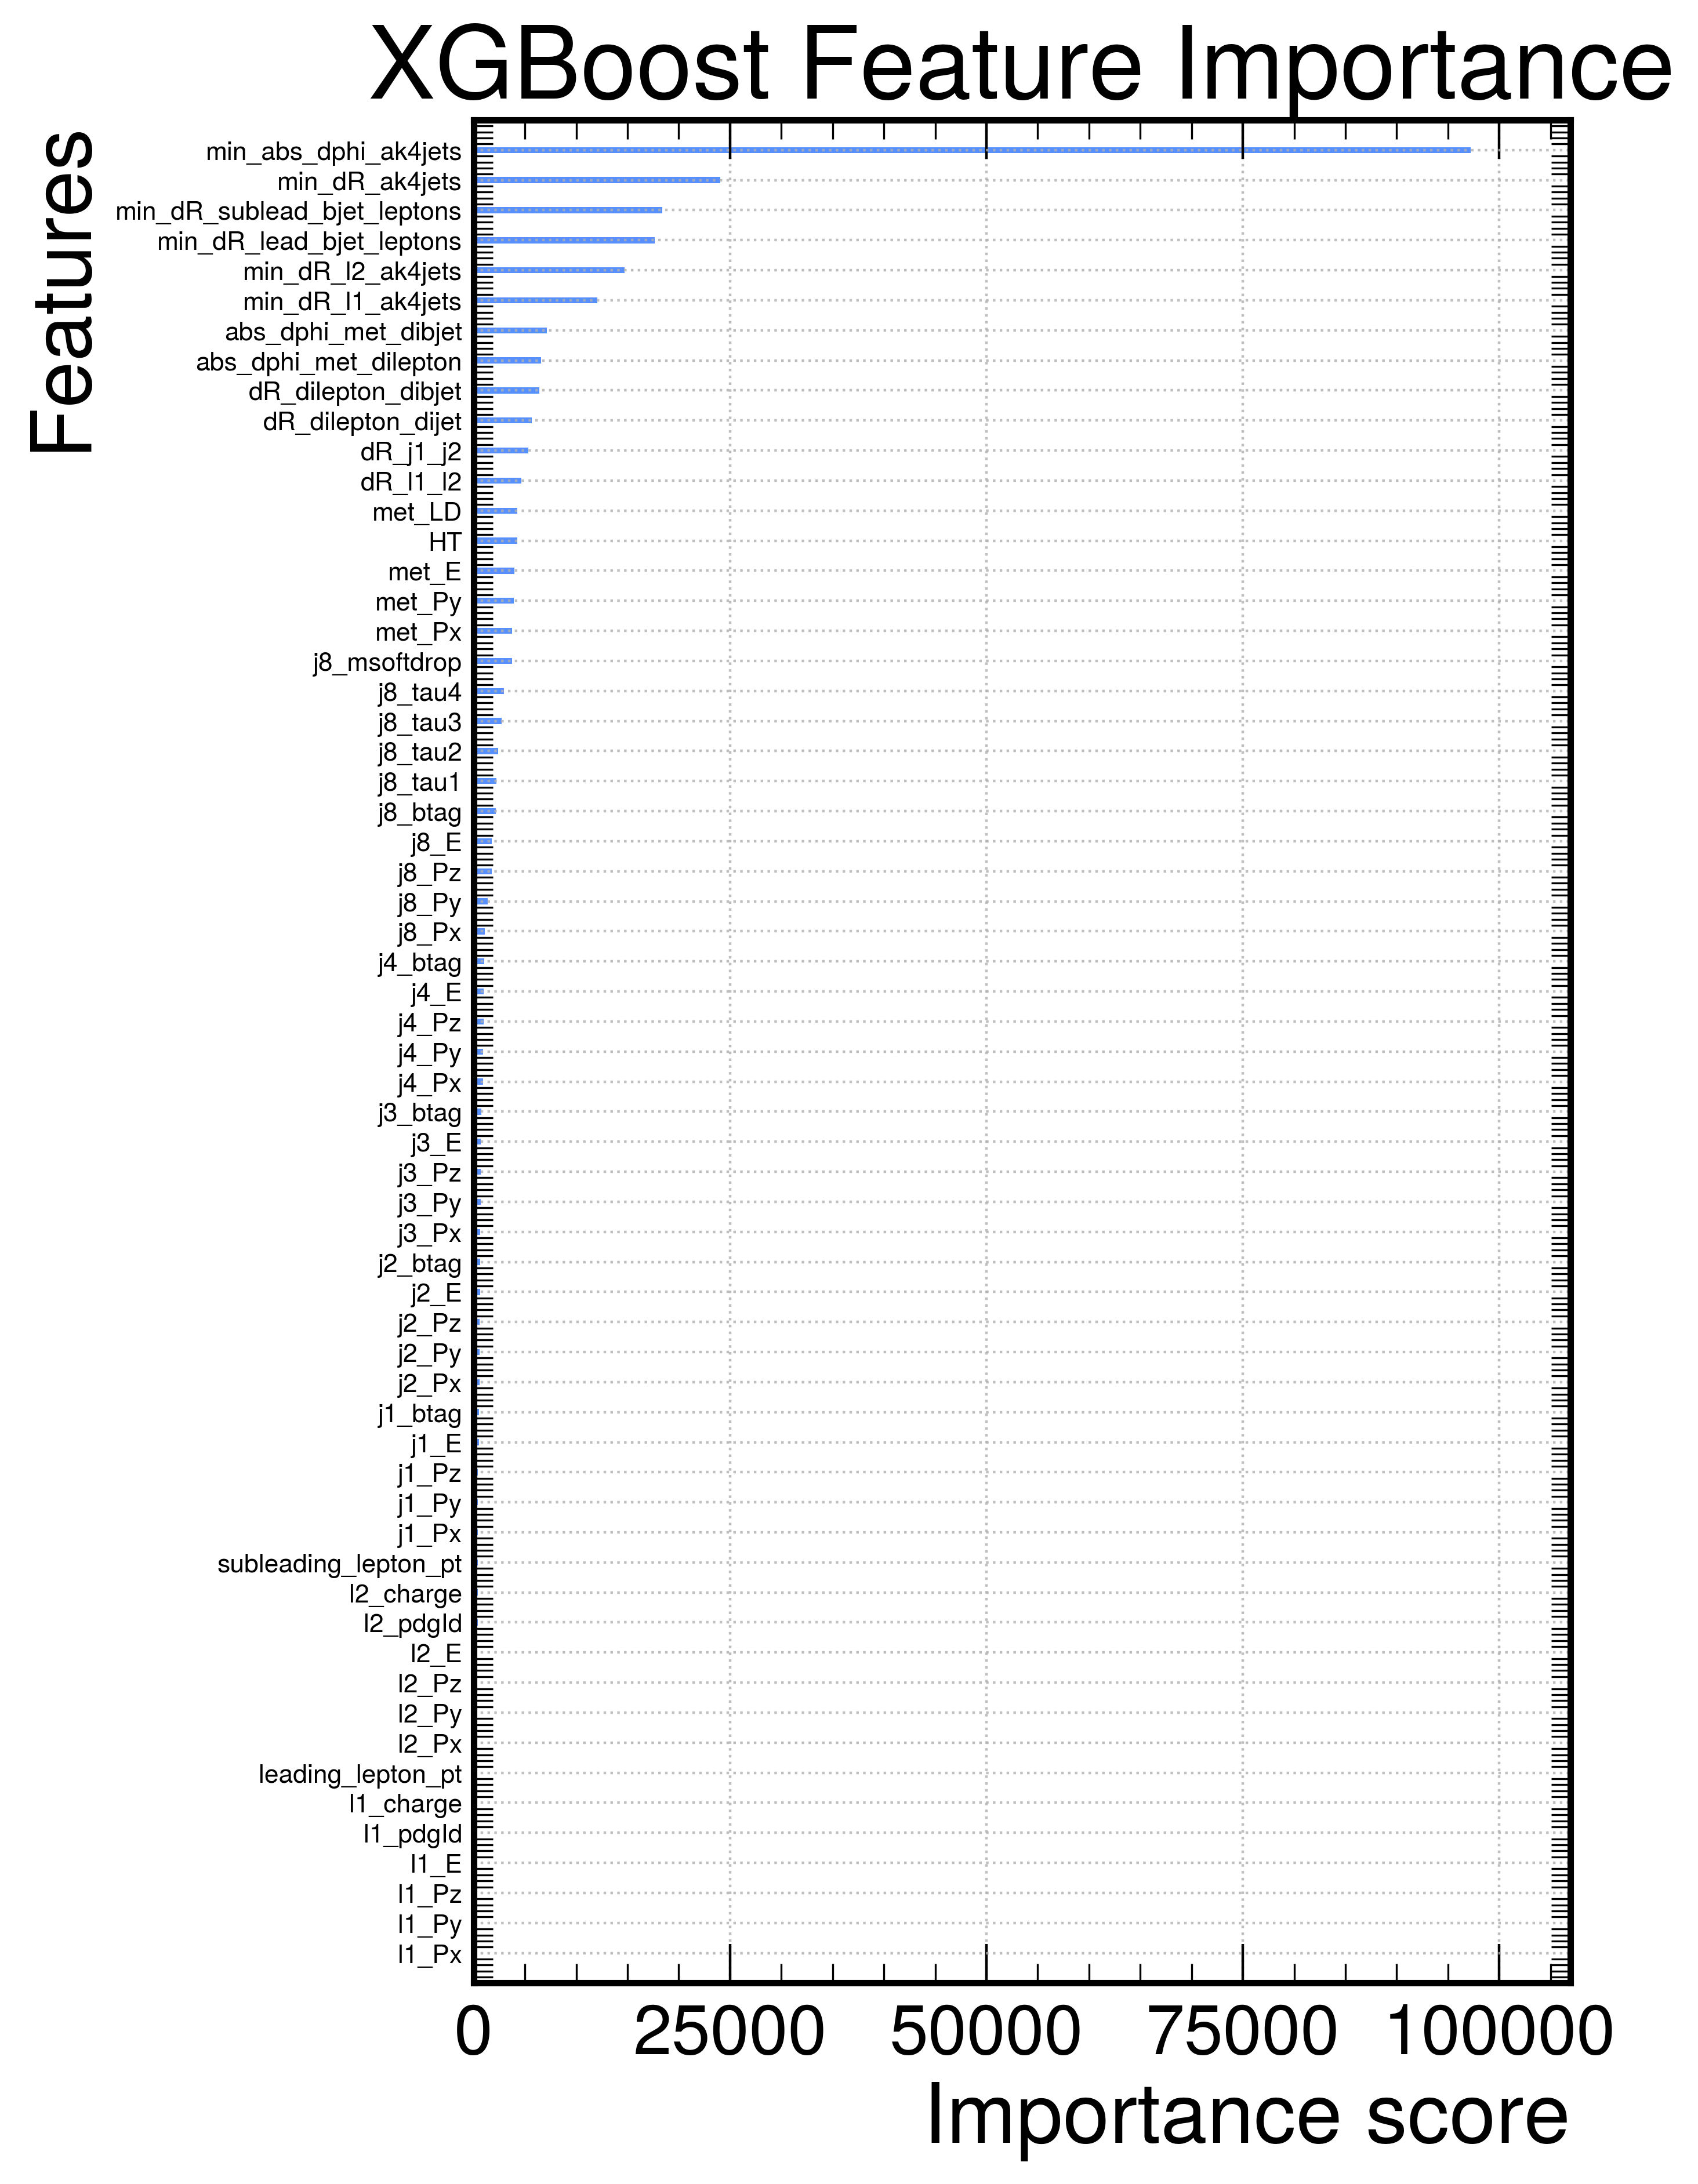

Feature importance plot saved to outputs_test/xgb_feature_importance.png


In [43]:
from xgboost import plot_importance

# Plot feature importance with feature names
plt.figure(figsize=(10, 6))
ax = plot_importance(
    bst,
    max_num_features=len(feature_cols),
    importance_type="gain",
    show_values=False,
)
feature_names = [col for col in df.columns if col not in ["HH", "bkg", "weight"]]
ax.set_yticklabels([feature_names[i] for i in range(len(ax.get_yticklabels()))])
plt.title("XGBoost Feature Importance")
plt.tight_layout()
ax.tick_params(axis="y", labelsize=8, length=0)  # Remove y-axis ticks
plt.savefig(f"{output_dir}/xgb_feature_importance.png")
plt.show()
print(f"Feature importance plot saved to {output_dir}/xgb_feature_importance.png")

In [30]:
# from sklearn.model_selection import StratifiedKFold

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
#     print(f"Fold {fold+1}")
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
#     w_train, weights_test = weights[train_idx], weights[test_idx]

#     dtrain_fold = xgb.DMatrix(X_train, label=y_train, weight=w_train)
#     dtest_fold = xgb.DMatrix(X_test, label=y_test, weight=weights_test)

#     evals_result_fold = {}
#     bst_fold = xgb.train(
#         params,
#         dtrain_fold,
#         num_boost_round=n_estimators,
#         evals=[(dtrain_fold, "train"), (dtest_fold, "test")],
#         verbose_eval=False,
#         evals_result=evals_result_fold
#     )
#     y_pred = bst_fold.predict(dtest_fold)
#     roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
#     print(f"ROC AUC (fold {fold+1}): {roc_auc:.4f}")

In [46]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

onnx_model = onnxmltools.convert_xgboost(
    bst,
    initial_types=[("float_input", FloatTensorType([None, X_train.shape[1]]))],
)
onnx_path = f"{output_dir}/model.onnx"
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())
print(f"XGBoost model exported to {onnx_path}")

XGBoost model exported to outputs_test/model.onnx


In [47]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession(onnx_path)
input_name = sess.get_inputs()[0].name
output_names = [o.name for o in sess.get_outputs()]

# Example input: use a real sample from your training data
signal_sample = df[df.HH == 1].sample(n=100000, random_state=seed)[feature_cols].values
bkg_sample = df[df.bkg == 1].sample(n=100000, random_state=seed)[feature_cols].values

signal_outputs = sess.run(output_names, {input_name: signal_sample.astype(np.float32)})
bkg_outputs = sess.run(output_names, {input_name: bkg_sample.astype(np.float32)})
signal_probs = signal_outputs[1]
bkg_probs = bkg_outputs[1]

ONNX model output probabilities saved to outputs_test/onnx_model_output_probs.png


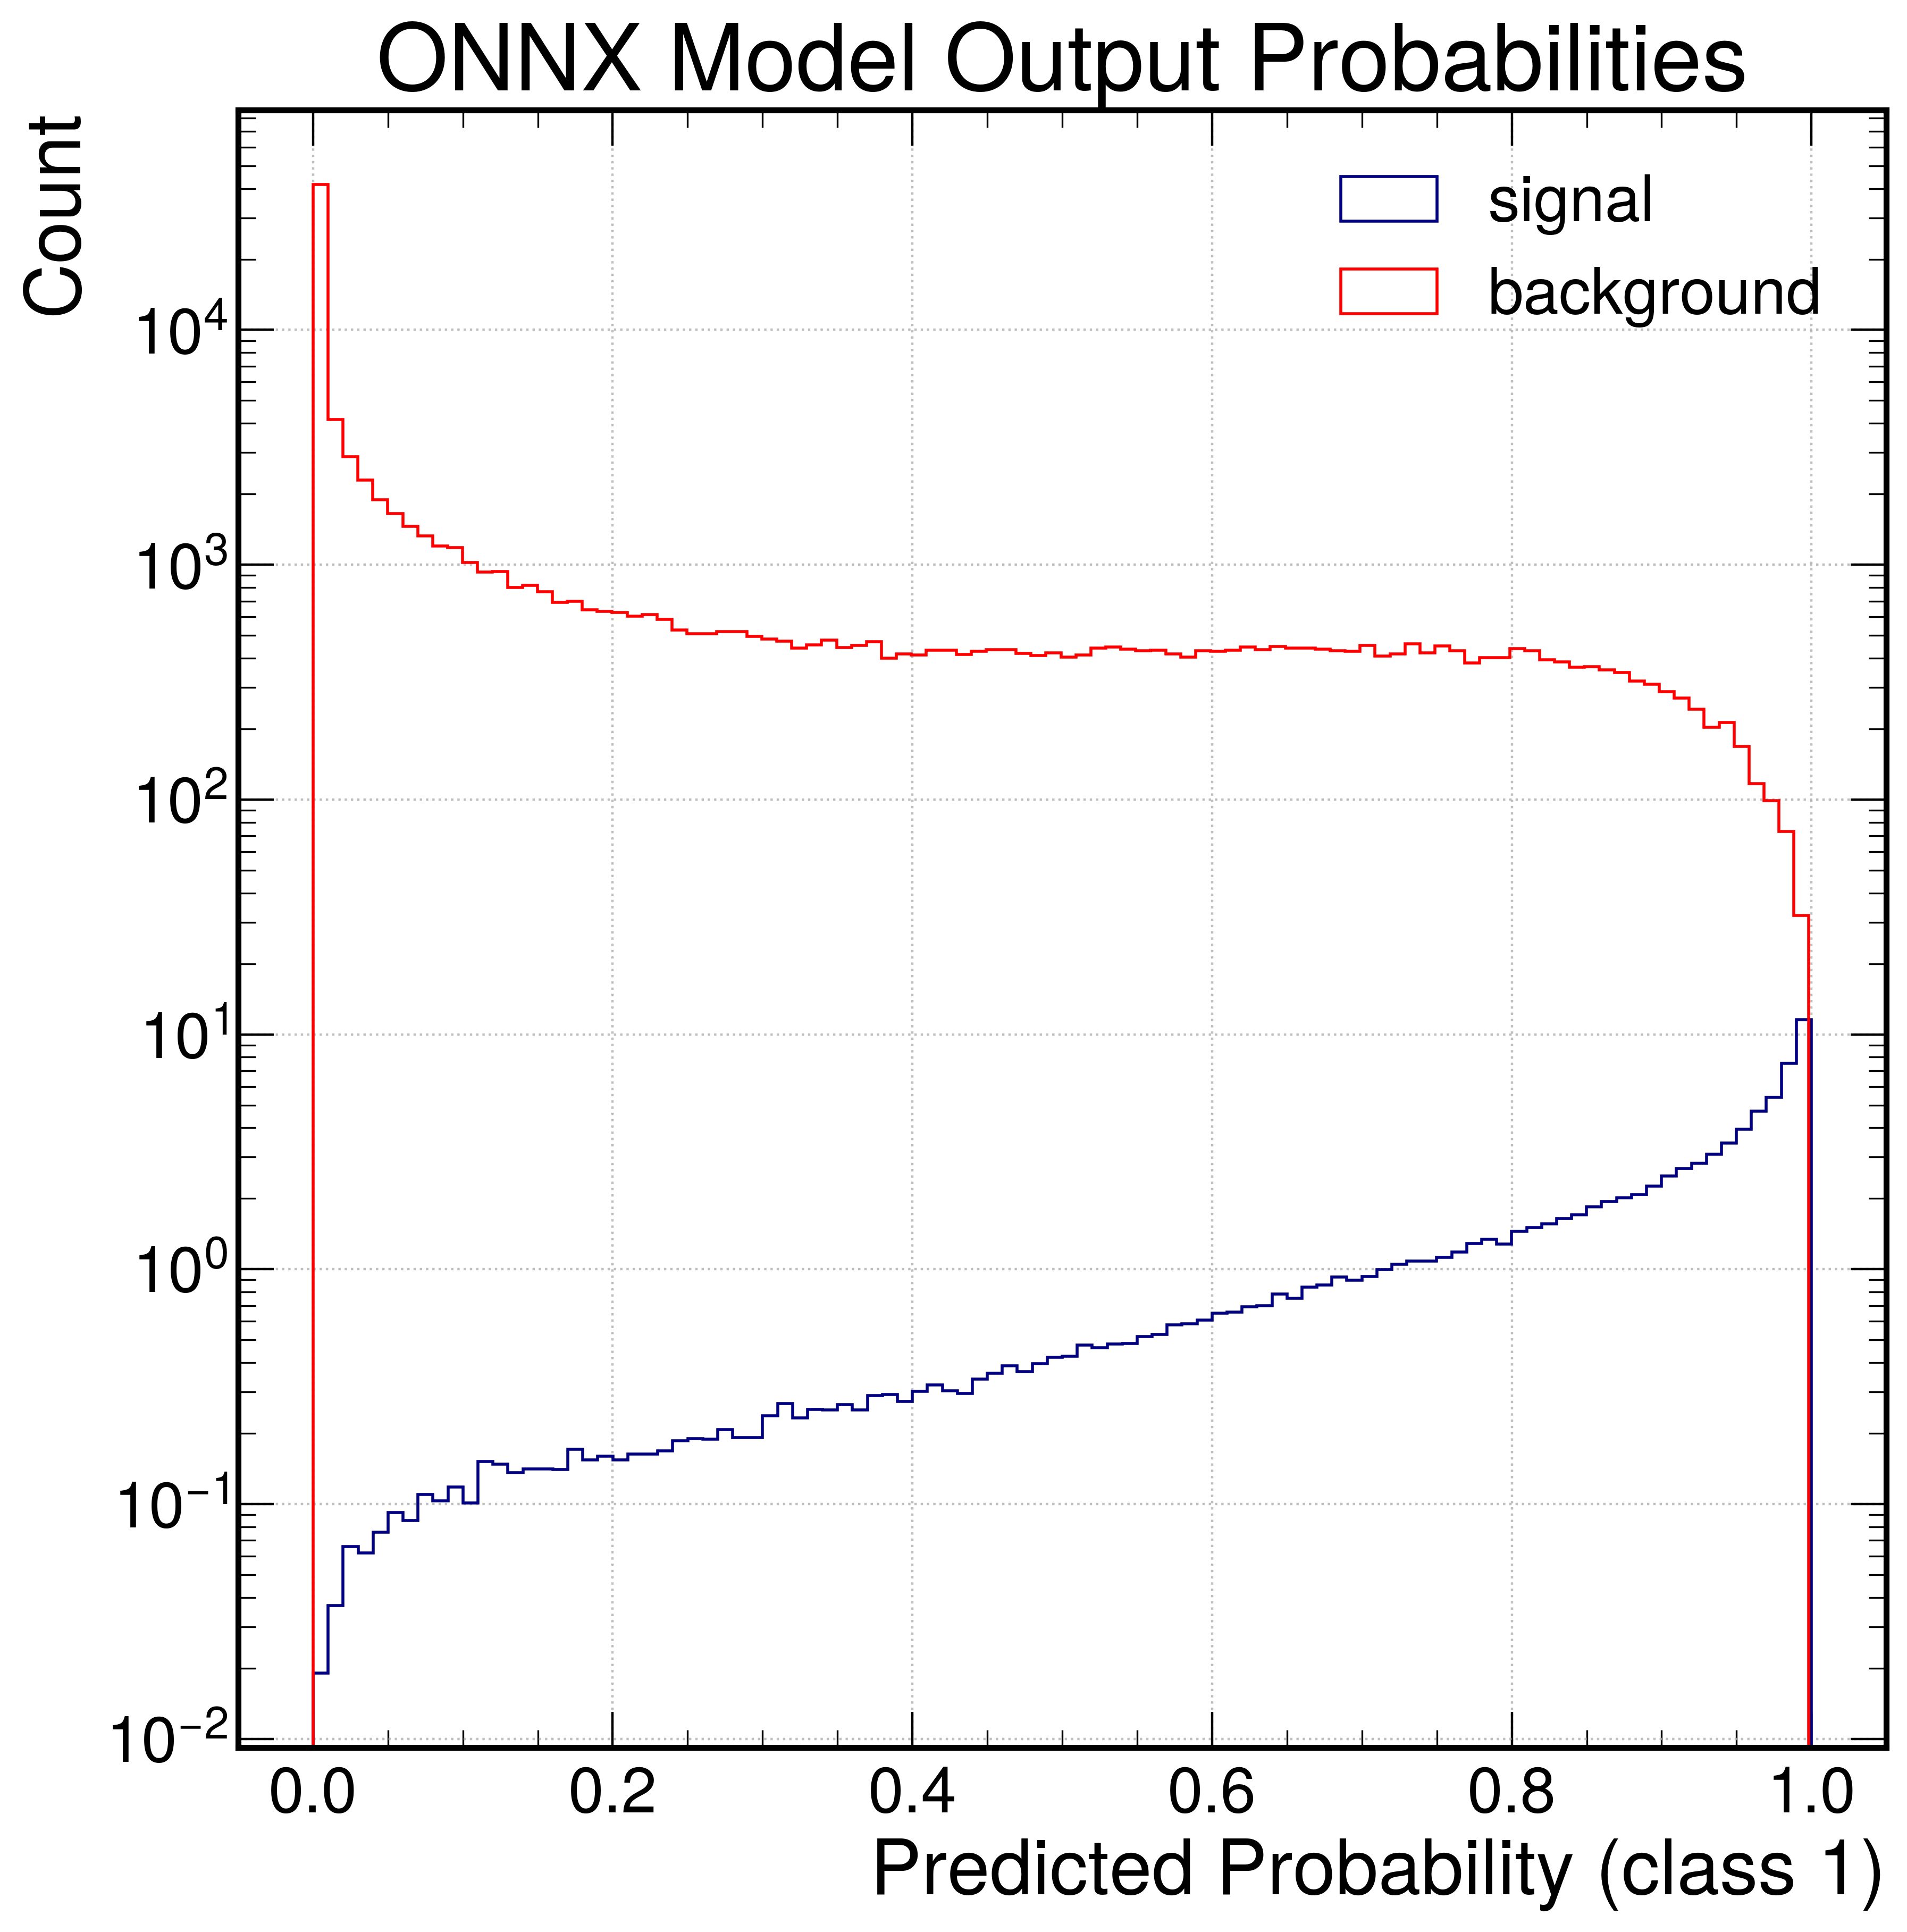

In [48]:
plt.figure()
plt.hist(
    signal_probs[:, 1],
    bins=100,
    color="navy",
    histtype="step",
    label="signal",
    density=True
)
plt.hist(
    bkg_probs[:, 1],
    bins=100,
    color="red",
    histtype="step",
    label="background",
    density=False
)
plt.xlabel("Predicted Probability (class 1)")
plt.ylabel("Count")
plt.title("ONNX Model Output Probabilities")
plt.grid(True)
plt.gca().set_yscale("log")
plt.legend()
plt.savefig(f"{output_dir}/onnx_model_output_probs.png")
print(f"ONNX model output probabilities saved to {output_dir}/onnx_model_output_probs.png")